In [65]:
import numpy as np
import scipy.signal as signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

sys.path.insert(0, '/home/leo_dacasi/Dokumente/summerofcode/ENFify/sources')

from ENF_frequency_phase_estimation import phase_estimation_DFT1,  phase_estimation_DFT1, segmented_freq_estimation_DFT0, hilbert_instantaneous_freq, scipy_IF_estimation
from ENF_preprocessing import generate_s_tone, list_files_in_directory, downsampling, bandpass_filter
#from ENF_Enhancement import RFA, VariationalModeDecomposition

import soundfile as sf
from pydub import AudioSegment
from scipy.signal import hilbert
import math
import cmath

3861649


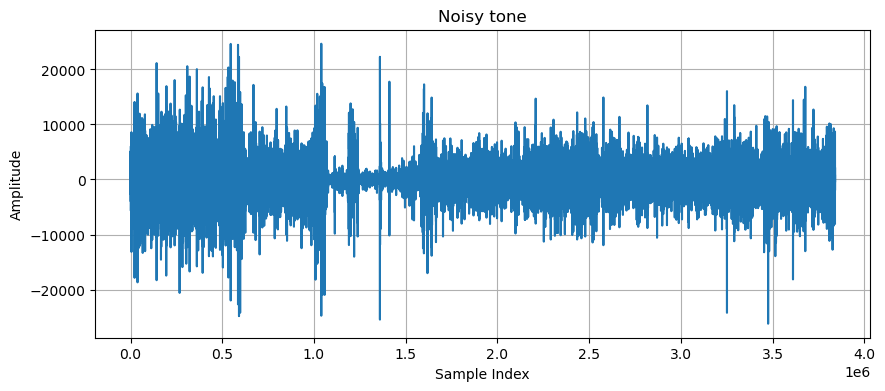

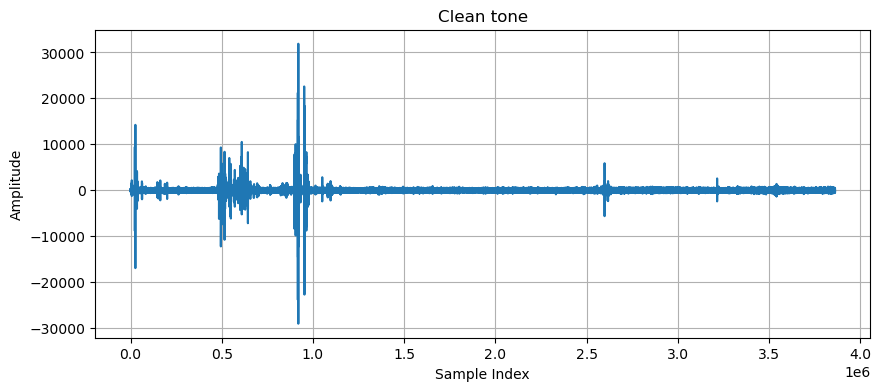

In [66]:
noise_fs, noise_data = wavfile.read('Wuhan_ENF_data/01.wav')
clean_fs, clean_data = wavfile.read('Wuhan_ENF_data/001.wav')

n_noise = np.arange(len(noise_data))
n_clean = np.arange(len(clean_data))

print(len(clean_data))

plt.figure(figsize=(10, 4))
plt.plot(n_noise, noise_data)
plt.title('Noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_clean, clean_data)
plt.title('Clean tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [22]:
dir = 'Wuhan_ENF_data'
rawFile_name, downFile_name = list_files_in_directory(dir)


for i in range(len(rawFile_name)):
    downsampling(rawFile_name[i], downFile_name[i], fs_down = 1000)

Wuhan_ENF_data/down_01.wav


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-13)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-lib

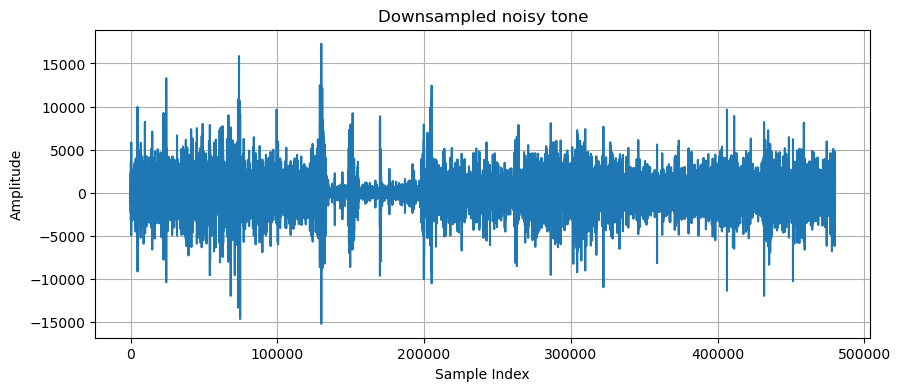

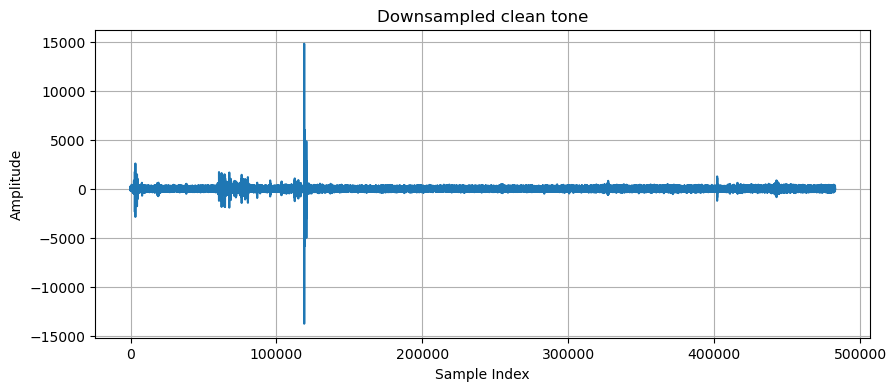

482003


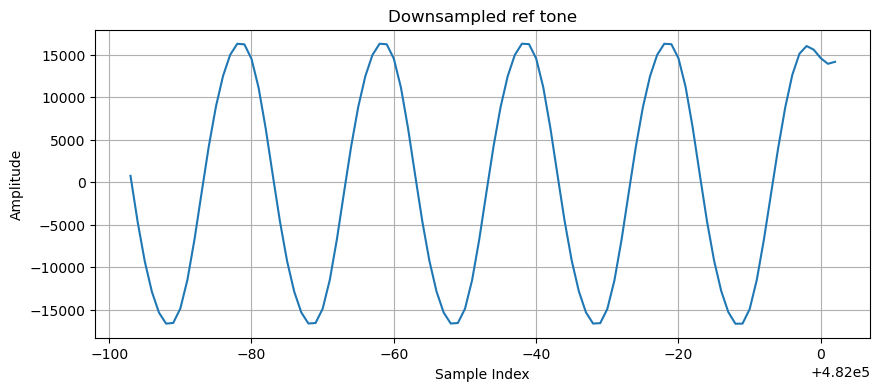

In [69]:
noise_fs, down_sig_noise = wavfile.read('Wuhan_ENF_data/down_01.wav')
clean_fs, down_sig_clean = wavfile.read('Wuhan_ENF_data/down_001.wav')
ref_fs, down_sig_ref = wavfile.read('Wuhan_ENF_data/down_001_ref.wav')

n_noise = np.arange(len(down_sig_noise))
n_clean = np.arange(len(down_sig_clean))
n_ref = np.arange(len(down_sig_ref))

#print(clean_fs)

plt.figure(figsize=(10, 4))
plt.plot(n_noise, down_sig_noise)
plt.title('Downsampled noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(n_clean, down_sig_clean)
plt.title('Downsampled clean tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

print(len(down_sig_ref))

plt.figure(figsize=(10, 4))
plt.plot(n_ref[482003-100:482003], down_sig_ref[482003-100:482003])
plt.title('Downsampled ref tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

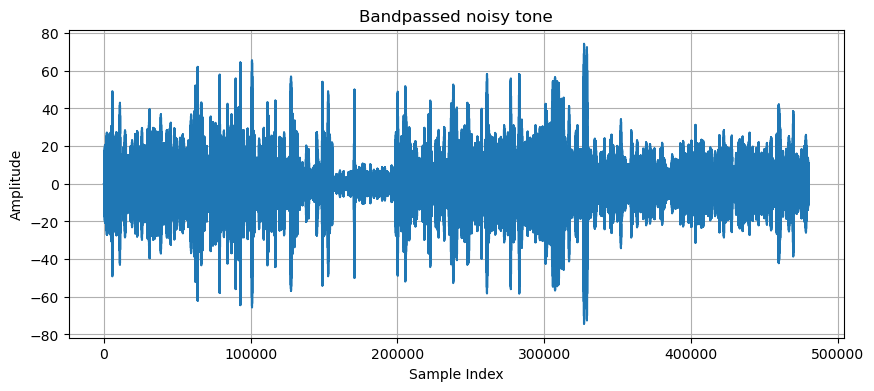

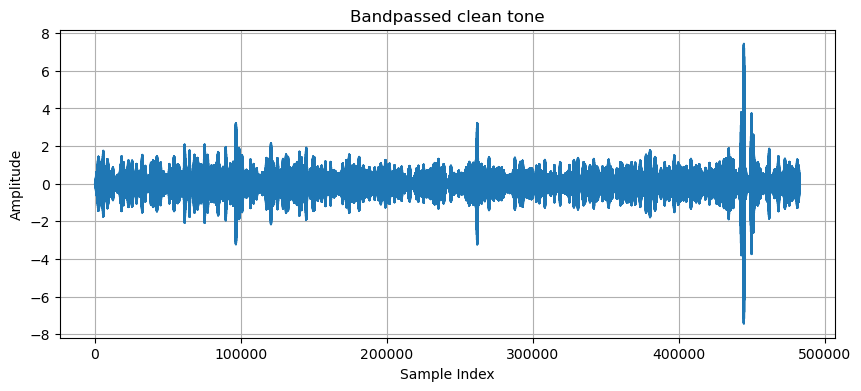

In [4]:
bandpass_noise = bandpass_filter(down_sig_noise, 49, 51, 1000, 4)
n_noise = np.arange(len(bandpass_noise))

plt.figure(figsize=(10, 4))
plt.plot(n_noise, bandpass_noise)
plt.title('Bandpassed noisy tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

bandpass_clean = bandpass_filter(down_sig_clean, 49.5, 50.5, 1000, 4)
n_clean = np.arange(len(bandpass_clean))

plt.figure(figsize=(10, 4))
plt.plot(n_clean, bandpass_clean)
plt.title('Bandpassed clean tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig("Bandpassed_clean_signal")
plt.show()


In [5]:
# Reference signal
ref_fs, down_sig_ref = wavfile.read('Wuhan_ENF_data/down_001_ref.wav')
bandpass_ref = bandpass_filter(down_sig_ref, 49.5, 50.5, 1000, 4)

peak_freqs_ref = segmented_freq_estimation_DFT1(bandpass_ref, clean_fs, num_cycles = 200, N_DFT= 20_000, nominal_enf=50)

#peak_freqs = freq_estimation(bandpass_clean, clean_fs)
peak_freqs_band = segmented_freq_estimation_DFT1(bandpass_clean, clean_fs, num_cycles = 200, N_DFT= 20_000, nominal_enf=50)


# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(peak_freqs_band)
plt.plot(peak_freqs_ref, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()


clean_sig_len = int(len(bandpass_clean)/len(peak_freqs_band))
estimated_clean_freqs = np.ones(len(bandpass_clean))
for i in range(len(peak_freqs_band)):
    estimated_clean_freqs[i*clean_sig_len:(2*clean_sig_len + 2*i*clean_sig_len)] = peak_freqs_band[i]

ref_sig_len = int(len(bandpass_ref)/len(peak_freqs_ref))
estimated_ref_freqs = np.ones(len(bandpass_ref))
for i in range(len(peak_freqs_ref)):
    estimated_ref_freqs[i*ref_sig_len:(2*clean_sig_len + 2*i*ref_sig_len)] = peak_freqs_ref[i]
    
    
# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(estimated_clean_freqs)
plt.plot(estimated_ref_freqs, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()



In [ ]:
tau = int(750)
estimated_enf = 50
I = 3
epsilon = 1e-7
fs = 1000
sig = bandpass_clean 
RFA(sig, fs, tau, epsilon, I, estimated_enf)

In [ ]:
fs =1000
f0 = 50
phi0 = np.pi/4
M = 1000
t,x = generate_s_tone(fs, f0, phi0, M)
I = 3
epsilon = 1e-20
tau = int(750)

rfa_test = RFA(x, fs, tau, epsilon, I, f0)

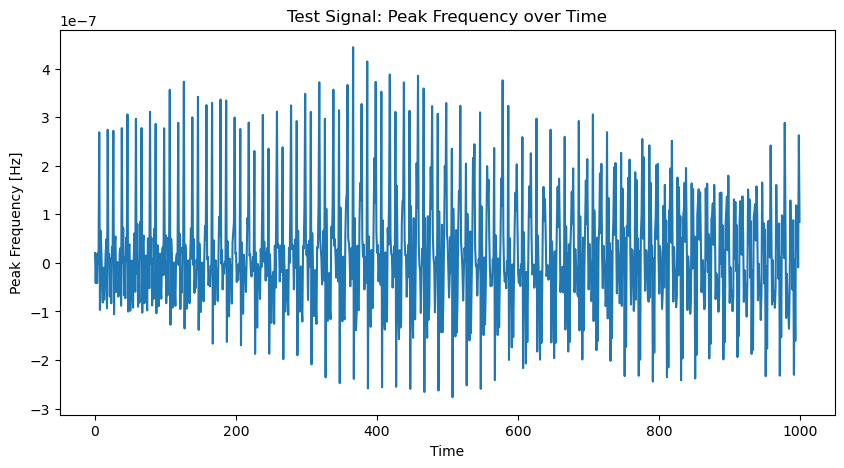

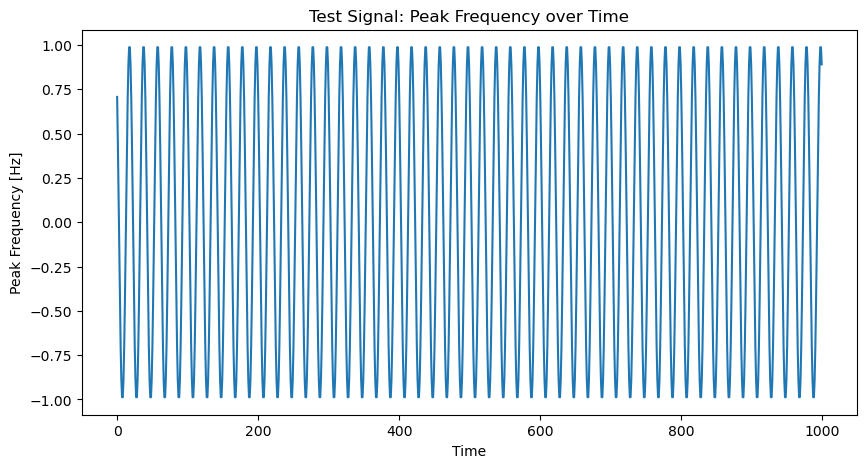

In [34]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(rfa_test)),rfa_test)
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(x)),x)
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()

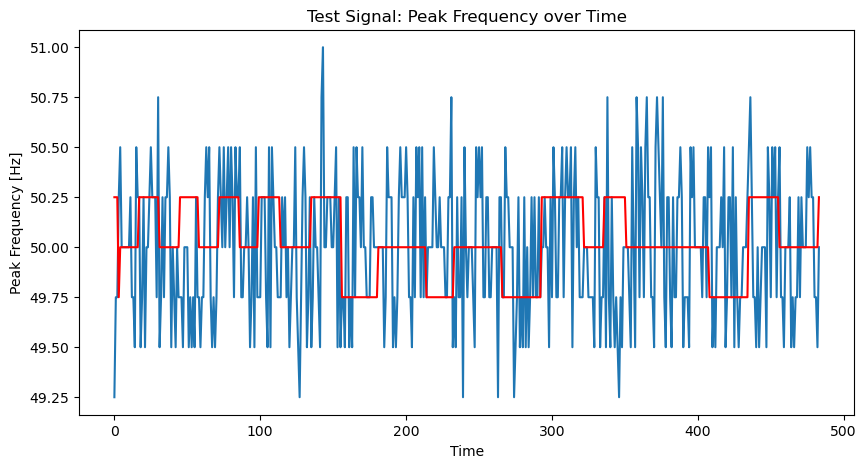

482003


In [34]:
# Reference signal
ref_fs, down_sig_ref = wavfile.read('Wuhan_ENF_data/down_001_ref.wav')
bandpass_ref = bandpass_filter(down_sig_ref, 49.5, 50.5, 1000, 4)
window = 'hann'
nperseg = 4*fs

f_ref, t_ref, Zxx_ref = signal.stft(bandpass_ref, fs=ref_fs, window=window, nperseg=nperseg, noverlap = 3*fs)
f_band, t_band, Zxx_band = signal.stft(bandpass_clean, fs=clean_fs, window=window, nperseg=nperseg, noverlap = 3*fs)

peak_freqs_ref = [f_ref[idx] for k in range(len(t_ref)) if (idx := np.argmax(Zxx_ref[:,k]))]
peak_freqs_band = [f_band[idx] for k in range(len(t_band)) if (idx := np.argmax(Zxx_band[:,k]))]

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(peak_freqs_band)
plt.plot(np.arange(len(peak_freqs_ref)),peak_freqs_ref, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()
print(len(bandpass_ref))

In [14]:
alpha = 200000 # moderate bandwidth constraint
#alpha = 1/4 * clean_fs * np.max(bandpass_clean)
tau = 0 
n_mode = 1
DC = 0  # no DC part imposed  
tol = 1e-7
u_clean, u_hat_clean, omega_clean = VariationalModeDecomposition(bandpass_clean, alpha, tau, n_mode, DC, tol)

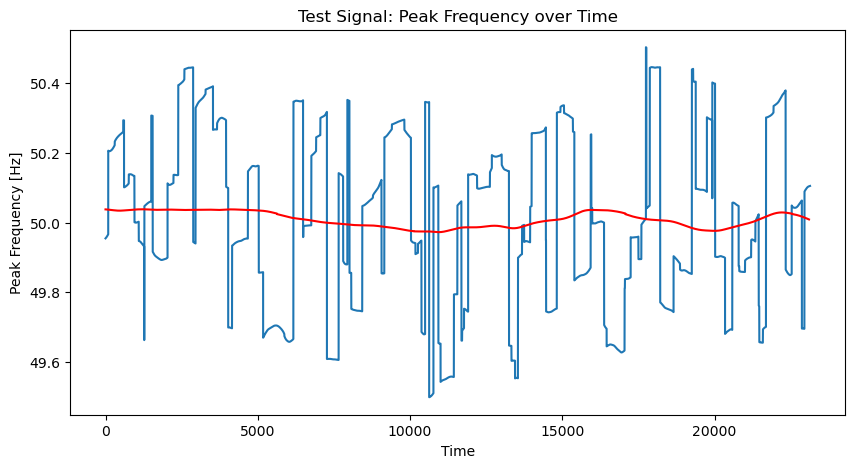

In [15]:
peak_freqs_vmd = segmented_freq_estimation_DFT1(u_clean[0], clean_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(peak_freqs_vmd)
plt.plot(peak_freqs_ref, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time')
plt.title("Test Signal: Peak Frequency over Time")
plt.show()


In [ ]:
peak_freqs = segmented_freq_estimation_DFT1(bandpass_noise, noise_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(peak_freqs)
plt.plot(peak_freqs_ref, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Test Signal: Peak Frequency over Time")
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

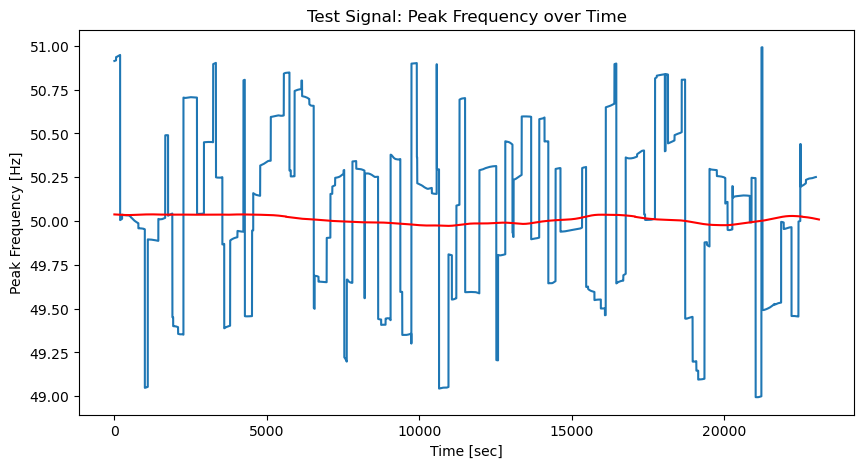

In [40]:
alpha = 2000 # moderate bandwidth constraint
tau = 0 
n_mode = 1
DC = 0  # no DC part imposed  
tol = 1e-7

u_noise, u_hat_noise, omega_noise = VariationalModeDecomposition(bandpass_noise, alpha, tau, n_mode, DC, tol)
freqs_vmd_noise = segmented_freq_estimation_DFT1(u_noise[0], clean_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

# Plot the peak frequency extracted from the test signal
plt.figure(figsize=(10,5))
plt.plot(freqs_vmd_noise)
plt.plot(peak_freqs_ref, color='red')
plt.ylabel('Peak Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Test Signal: Peak Frequency over Time")
plt.plot

In [42]:
dir = 'Talkbank_data'
rawFile_name, downFile_name = list_files_in_directory(dir)
for i in range(len(rawFile_name)):
    downsampling(rawFile_name[i], downFile_name[i], fs_down = 1000)

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-13)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1719926049773/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-lib

1000
[  6.  -21.5 -34.5 ...  -5.   -4.   -5.5]


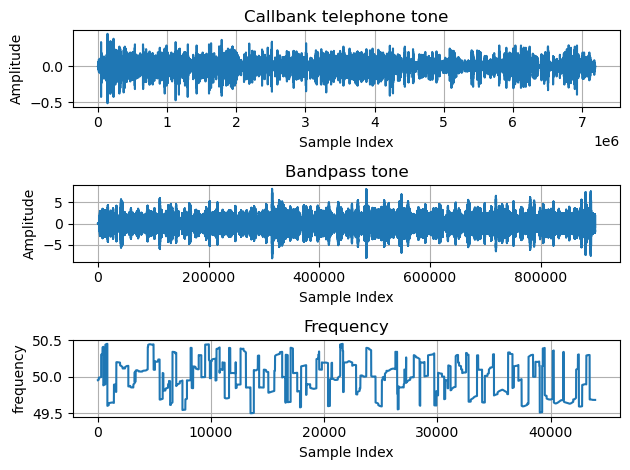

In [46]:
###.........................Talk_bank......................###

noise_data, noise_fs = sf.read('Talkbank_data/1082.wav')
noise_data = np.mean(noise_data, axis=1)
n_noise = np.arange(len(noise_data))

plt.figure()
plt.subplot(3,1,1)
plt.plot(n_noise, noise_data)
plt.title('Callbank telephone tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()


talkbank_fs, down_sig_talkbank = wavfile.read('Talkbank_data/down_1082.wav')
down_sig_talkbank = np.mean(down_sig_talkbank, axis=1)
bandpass_talkbank = bandpass_filter(down_sig_talkbank, 49.5, 50.5, talkbank_fs, 4)
n_talkbank = np.arange(len(bandpass_talkbank))

print(talkbank_fs)
print(down_sig_talkbank)

plt.subplot(3,1,2)
plt.plot(n_talkbank, bandpass_talkbank)
plt.title('Bandpass tone')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

inst_freq_talkbank = segmented_freq_estimation_DFT1(bandpass_talkbank, talkbank_fs, num_cycles = 1000, N_DFT= 20_000, nominal_enf=50)

plt.subplot(3,1,3)
plt.plot(inst_freq_talkbank)
plt.title('Frequency')
plt.xlabel('Sample Index')
plt.ylabel('frequency')
plt.grid()
plt.tight_layout()


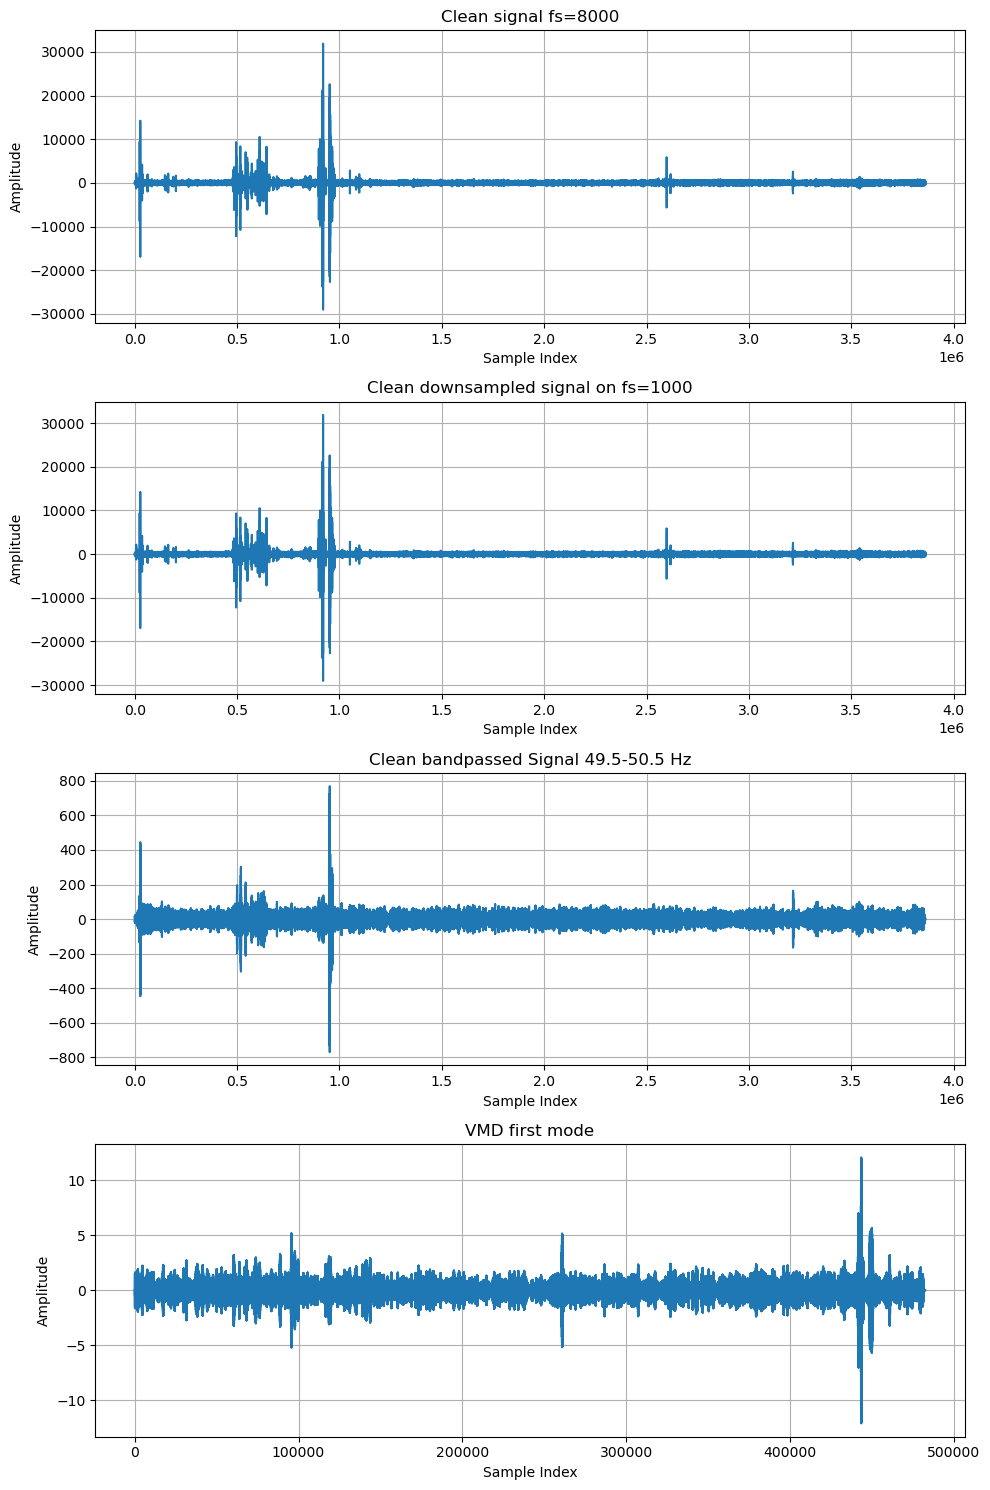

In [13]:
### Clean plot
_, clean_data = wavfile.read('Wuhan_ENF_data/001.wav')
n_clean = np.arange(len(clean_data ))

clean_fs, downsampled_clean = wavfile.read('Wuhan_ENF_data/001.wav')
n_clean_down = np.arange(len(downsampled_clean))

bandpass_clean = bandpass_filter(downsampled_clean, 49.5, 50.5, 1000, 4)
n_clean_band = np.arange(len(bandpass_clean))

vmd = u[0]
n_vmd = np.arange(len(u[0]))

plt.figure(figsize=(10, 15))

plt.subplot(4,1,1)
plt.plot(n_clean, clean_data)
plt.title('Clean signal fs=8000')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,2)
plt.plot(n_clean_down, downsampled_clean)
plt.title('Clean downsampled signal on fs=1000')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,3)
plt.plot(n_clean_band , bandpass_clean)
plt.title('Clean bandpassed Signal 49.5-50.5 Hz')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,4)
plt.plot(n_vmd, vmd)
plt.title('VMD first mode')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
#plt.savefig("clean_signal_amplitude")

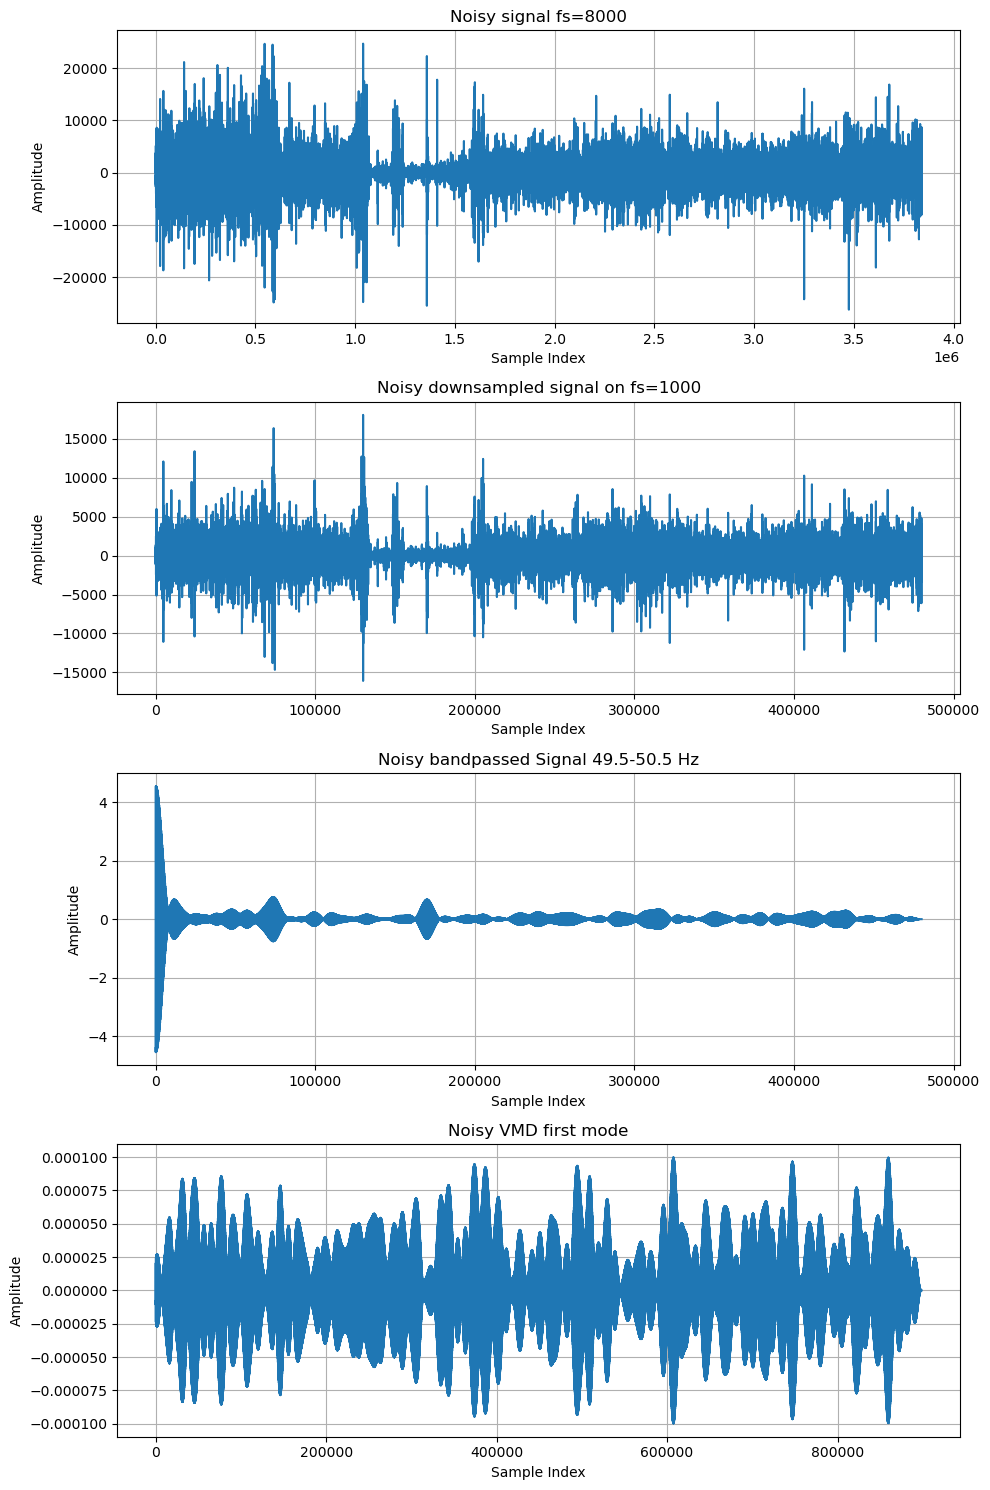

In [91]:
### Clean plot
clean_fs, clean_data = wavfile.read('Wuhan_ENF_data/01.wav')
n_clean = np.arange(len(clean_data))

downsampled_clean = downsampling(clean_data, clean_fs, f_ds=1000)
n_clean_down = np.arange(len(downsampled_clean))

bandpass_clean = bandpass_filter(downsampled_clean, 49.5, 50.5, 8000, 3)
n_clean_band = np.arange(len(bandpass_clean))

vmd = u_noise[0]
n_vmd = np.arange(len(u_noise[0]))

plt.figure(figsize=(10, 15))

plt.subplot(4,1,1)
plt.plot(n_clean, clean_data)
plt.title('Noisy signal fs=8000')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,2)
plt.plot(n_clean_down, downsampled_clean)
plt.title('Noisy downsampled signal on fs=1000')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,3)
plt.plot(n_clean_band , bandpass_clean)
plt.title('Noisy bandpassed Signal 49.5-50.5 Hz')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()

plt.subplot(4,1,4)
plt.plot(n_vmd, vmd)
plt.title('Noisy VMD first mode')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
#plt.savefig("noisy_signal_amplitude")

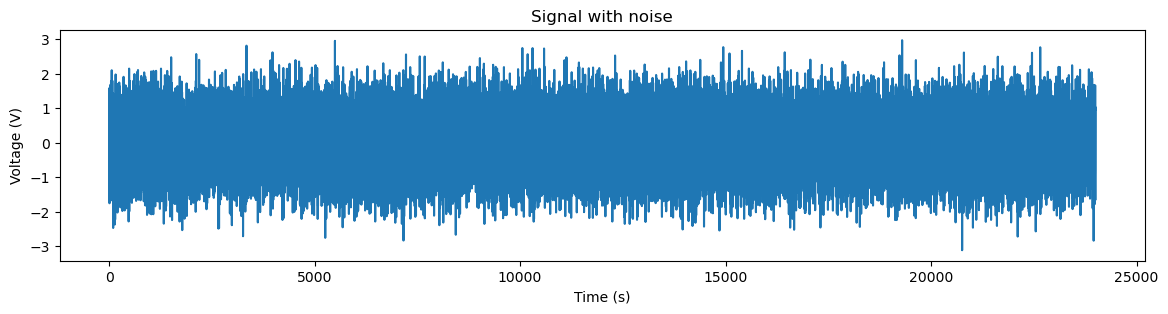

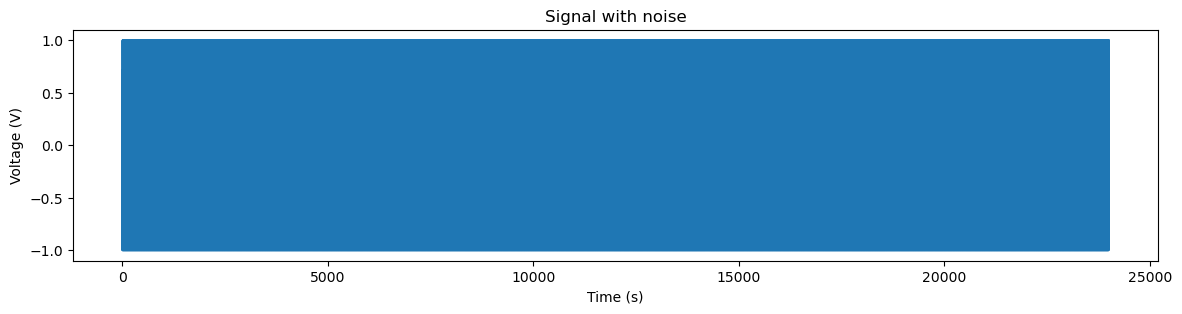

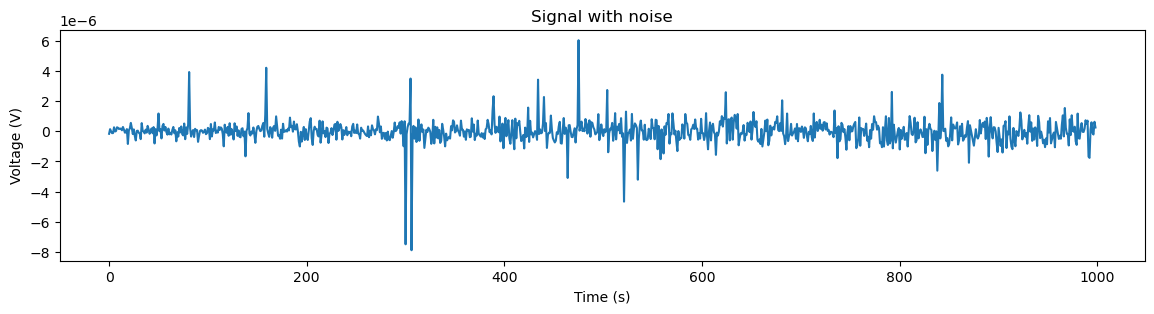

In [62]:
Fs = 400
f0 = 50
phi0 = np.pi/4
M = 60*Fs

n, s_n = generate_s_tone(Fs, f0, phi0, M) # Creating signal
s_watts = s_n** 2

# Adding noise using target SNR
# Set a target SNR
target_snr_db = 2

# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(s_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)

# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)

# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(s_watts))

# Noise up the original signal
s_n_noised = s_n + noise_volts

# Plot signal with noise
plt.figure(figsize=(14, 3))
plt.plot(s_n_noised)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(14, 3))
plt.plot(s_n)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

plt.figure(figsize=(14, 3))
plt.plot(rfa)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

In [49]:
###...........................RFA................................###
def z_SFM(sig, n , fs, alpha, tau):
    sum_sig = 0
    sig_padded = np.pad(sig, (tau, tau), 'constant')

    # n+tau
    for i in range(n+tau+1):
        sum_sig += sig_padded[i]
    z = cmath.exp(1j*2*math.pi*(1/fs)*alpha*sum_sig)
    return z


def z_SFM_complex(sig, n, fs, alpha, tau):
    sum_sig = 0
    sig_padded = np.pad(sig, (tau, tau), 'constant')

    # n-tau
    for i in range(n-tau+1):
        sum_sig += sig_padded[i]
    z = cmath.exp(-1j*2*math.pi*(1/fs)*alpha*sum_sig)
    return z


def kernel_function(sig, f, n, fs, alpha, tau):
    tau_dash = int(tau + np.round(fs/(4*f)))
    auto_corr = z_SFM(sig, n, fs, alpha, tau) * z_SFM_complex(sig, n, fs, alpha, tau)
    auto_corr_dash = z_SFM(sig, n, fs, alpha, tau_dash) * z_SFM_complex(sig, n, fs, alpha, tau_dash)
    
    Kernel = (auto_corr**((1/fs)*f*tau*math.pi*np.sin(2*math.pi*(1/fs)*f*tau)) 
              * auto_corr_dash**((1/fs)*f*tau*math.pi*np.cos(2*math.pi*(1/fs)*f*tau)))
    return Kernel

def segmented_freq_estimation_hilbert(s_in, f_s, num_cycles, nominal_enf):
    step_size = int(f_s // nominal_enf)  # samples per nominal enf cycle

    num_blocks = len(s_in) // step_size - (num_cycles - 1)

    segments = [s_in[i * step_size : (i + num_cycles) * step_size] for i in range(num_blocks)]

    freqs = []
    for i in range(len(segments)):
        freq = hilbert_instantaneous_freq(segments[i],f_s)
        freq = np.mean(freq)
        freqs.append(freq)

    freqs = np.array(freqs)
    
    return freqs

def RFA(sig, fs, tau, epsilon, I, estimated_enf):
    print("test")
    # Initialise
    k = 1
    Nx = len(sig)
    alpha = 1/4 * fs/np.max(sig)
    f_start = estimated_enf * np.ones(Nx)
    
    while k <= I:
        denoised_sig = []

        for n in tqdm(range(0, Nx-1)):
            f = f_start[n]
            phase_of_kernel = 0
            
            for m in range(1,tau+1):
                phase_of_kernel += np.angle(kernel_function(sig, f, n, fs, alpha, m))

            denoised_sig.append(phase_of_kernel/((tau+1)*tau*math.pi*alpha))
        print(denoised_sig)
        peak_freqs = segmented_freq_estimation_hilbert(denoised_sig, fs, num_cycles = 10, nominal_enf=estimated_enf)
        print(peak_freqs)
        sig_len = int(len(sig)/len(peak_freqs))
        new_freqs = np.ones(len(denoised_sig))

        for l in range(len(peak_freqs)):
            new_freqs[l*sig_len:(2*sig_len + 2*l*sig_len)] = peak_freqs[l]

        f = f_start
        numerator = 0
        denominator = 0
        

        for s in range(len(new_freqs)):
            numerator += (new_freqs[s]-f[s])**2
            denominator += (f[s])**2
        
        if numerator/denominator <= epsilon:
            return denoised_sig

        f_start = new_freqs
        sig = denoised_sig
        denoised_signal = denoised_sig
        k+=1
    return denoised_signal


In [ ]:
tau = int(750)
estimated_enf = 50
I = 1
epsilon = 1e-7
fs = 400
sig = s_n_noised
rfa = RFA(sig, fs, tau, epsilon, I, estimated_enf)

In [22]:
def hilbert_instantaneous_freq(signal, fs):
    analytic_sig = hilbert(signal)
    inst_phase  = np.unwrap(np.angle(analytic_sig))
    inst_freq = (np.diff(inst_phase)/(2.0*np.pi) * fs)
    inst_freq = np.append(inst_freq, inst_freq[-1]) # Diff reduces the number of results by 1 -> dulicate the last frequency
    return inst_freq

freqs = hilbert_instantaneous_freq(sig,400)
len(freqs)

1000

In [48]:
freqs = segmented_freq_estimation_hilbert(sig, 400, num_cycles=10, nominal_enf=50)
freqs

array([63.14655454, 54.703077  , 46.11575641, 54.64786556, 55.70251749,
       59.94575742, 62.34873283, 61.11256464, 60.11763565, 64.74502271,
       65.0142537 , 70.46297948, 76.12934429, 74.96902234, 80.50026971,
       79.55973485, 75.17349428, 80.11498861, 80.04235233, 72.05899519,
       75.48722309, 75.38221848, 75.6229213 , 74.32133538, 69.42727589,
       66.65291992, 64.05408458, 64.76528276, 59.88025486, 60.90393033,
       69.78830589, 64.9852676 , 63.89796344, 70.94958642, 70.08698883,
       78.25914084, 75.53440441, 71.02878515, 79.69523149, 80.01780238,
       84.35937661, 84.36297581, 77.84539365, 73.53452583, 75.19954415,
       70.15901346, 65.09429564, 59.53756834, 52.77965151, 63.62810977,
       60.14797075, 58.98595726, 69.13864482, 75.09750272, 70.15510813,
       79.48081083, 80.06540151, 79.98714982, 74.89151372, 74.17392702,
       75.52888308, 74.93111456, 71.98150185, 73.3483685 , 90.68241373,
       69.30601726, 70.84739048, 70.49249376, 64.85658818, 74.40

In [41]:
freqs = segmented_freq_estimation_DFT0(sig, 400, num_cycles=10, N_DFT=20_000, nominal_enf=50)
len(freqs)

116